# Dataset 1 - Red Wine Quality

## Importando as bibliotecas necessárias

In [146]:
import pandas as pd
import numpy as np
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO 
from pydot import graph_from_dot_data
from time import process_time

### Carregando o dataset

In [190]:
# Carrega o datasset
wine = pd.read_csv('winequality-red.csv')
wine2 = pd.read_csv('winequality-red.csv')

In [191]:
print("Valores faltantes:", wine.isnull().values.any())

Valores faltantes: False


In [192]:
# Printa 3 linhas do dataset
print(wine.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [193]:
print(wine.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [194]:
print(wine.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


## Algumas informações interessantes

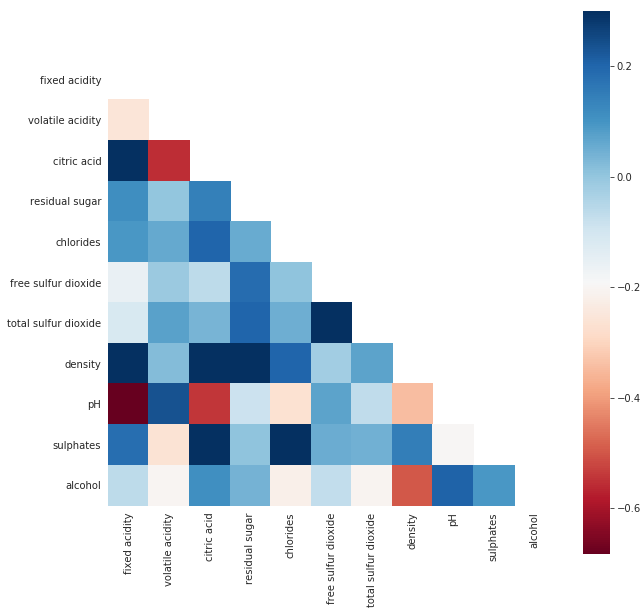

In [195]:
del wine2['quality']
corr = wine2.corr()    # data frame correlation function

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 10))

    ax = sns.heatmap(corr, mask=mask, cmap='RdBu', vmax=.3, square=True)

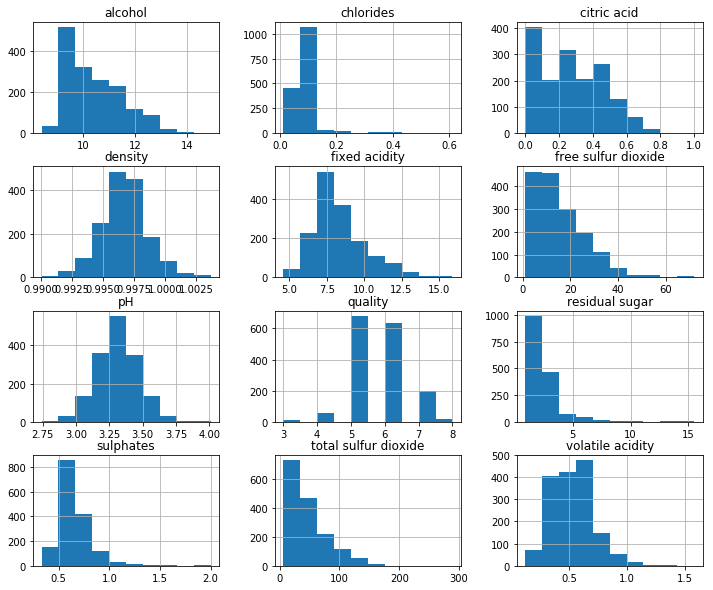

In [152]:
wine.hist(figsize=(12, 10))
plt.show()

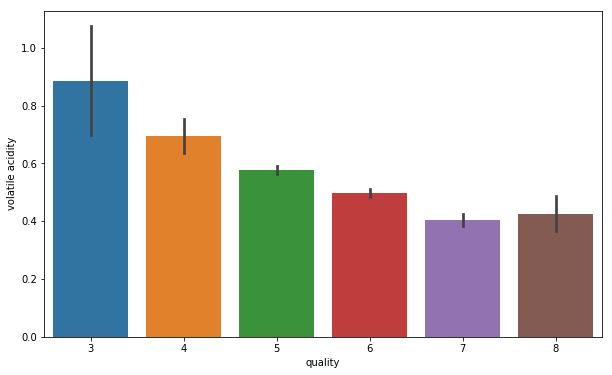

In [153]:
# Relação quality x volatile acidity
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'volatile acidity', data = wine)

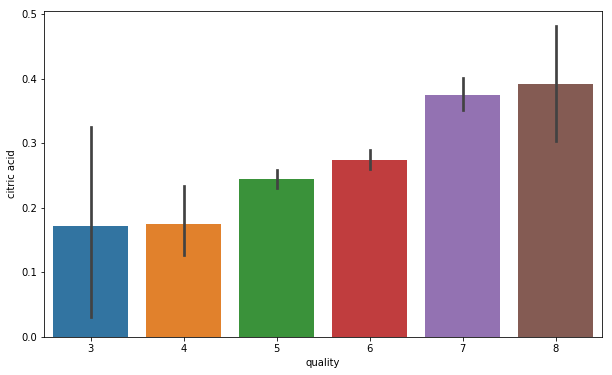

In [154]:
# Relação quality x citric acid
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'citric acid', data = wine)

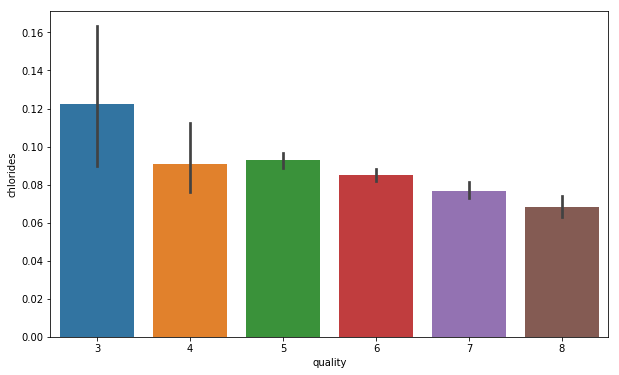

In [155]:
# Relação quality x chlorides
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'chlorides', data = wine)

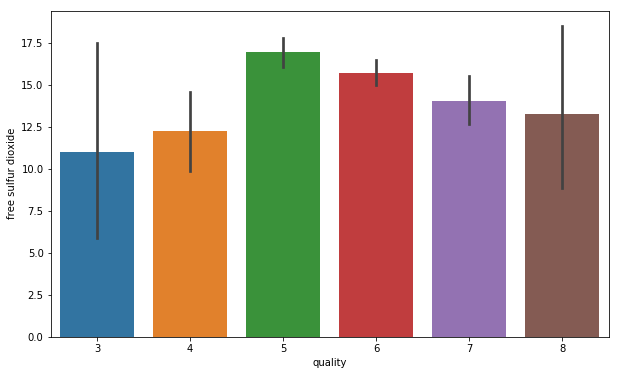

In [156]:
# Relação quality x free sulfur dioxide
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'free sulfur dioxide', data = wine)

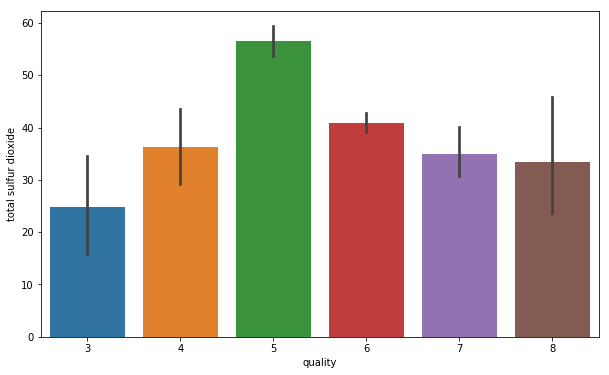

In [157]:
# Relação quality x total sulfur dioxide
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'total sulfur dioxide', data = wine)

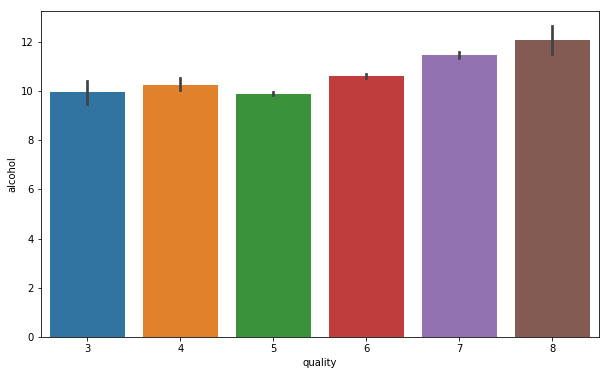

In [158]:
# Relação quality x alcohol
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'alcohol', data = wine)

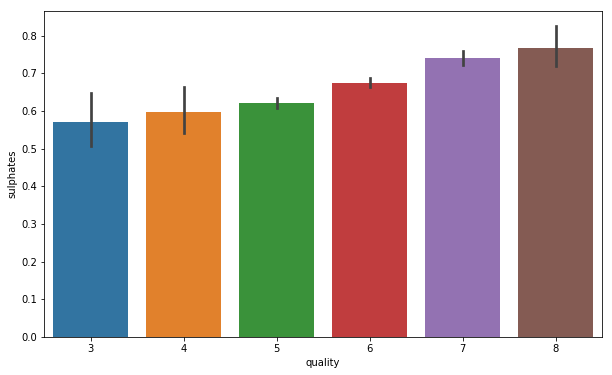

In [159]:
# Relação quality x sulphates
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'sulphates', data = wine)

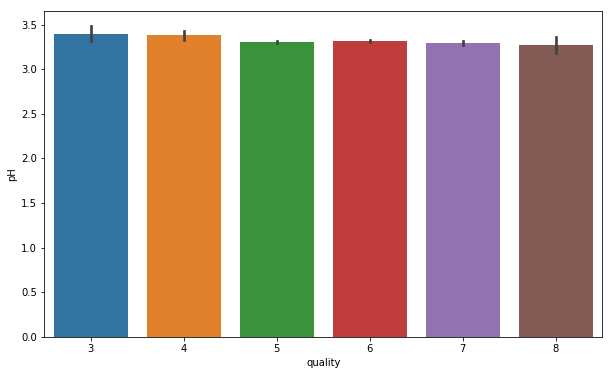

In [160]:
# Relação quality x sulphates
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'pH', data = wine)

# Pre-Processamento

In [161]:
# Como a qualidade esta como numeral e precisamos dela nominal para a classificação
# resolvemos classificar o vinho como apenas ruim ou bom, dessa forma
# definimos um intervalo na variação que antes era de 2 a 8
# em uma classificação binária
# agora os vinhos de 2 a 6.5 serão classificados como ruins
# e os vinhos acima de 6.6 serão classificados como bons
# sendo ruins = 0 e bons = 1
bins = (2, 6.5, 8)
group_names = ['ruim', 'bom']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [162]:
# Criando um codificador para converter a qualidade para numeral(0 e 1)
label_quality = LabelEncoder()

In [163]:
# Vinhos bons se tornarão 0 enquanto os ruins serão identificados por 1
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [164]:
num_true = len(wine.loc[wine['quality'] == 0])
num_false = len(wine.loc[wine['quality'] == 1])
print("Vinhos bonss:  {0} ({1:2.2f}%)".format(num_true, (num_true/ (num_true + num_false)) * 100))
print("vinhos ruins: {0} ({1:2.2f}%)".format(num_false, (num_false/ (num_true + num_false)) * 100))

Vinhos bonss:  217 (13.57%)
vinhos ruins: 1382 (86.43%)


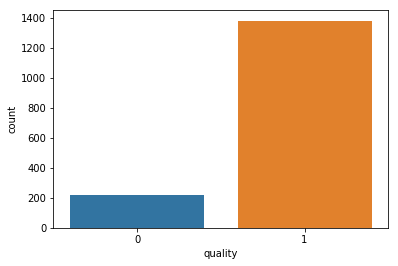

In [165]:
# Plota a relação quality x quantidade
sns.countplot(wine['quality'])

# Divisão do dataset

In [166]:
# Divisão dos vetores de caracteristicas e rotulos
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [167]:
# Divisão do dataset: 75% para treino, 25% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [168]:
print("Quantidade de amostras no treino: {0:0.2f}% ".format((len(X_train)/len(wine.index)) * 100))
print(X_train.shape)
print(y_train.shape)

Quantidade de amostras no treino: 74.98% 
(1199, 11)
(1199,)


In [169]:
print("Quantidade de amostras no teste: {0:0.2f}%".format((len(X_test)/len(wine.index)) * 100))
print(X_test.shape)
print(y_test.shape)

Quantidade de amostras no teste: 25.02%
(400, 11)
(400,)


# Classificação

### Criação do modelo Naive Bayes Gaussian

In [188]:
nbc =  GaussianNB()

### Treinamento do modelo

In [ ]:
nbc.fit(X_train, y_train)

### Teste do modelo

In [172]:
pred_nbc = nbc.predict(X_test)

In [173]:
acuracia_nbc = accuracy_score(y_test, pred_nbc)
print("Acurácia:", acuracia_nbc)

Acurácia: 0.8525


In [174]:
print(classification_report(y_test, pred_nbc))

              precision    recall  f1-score   support

           0       0.47      0.75      0.58        53
           1       0.96      0.87      0.91       347

    accuracy                           0.85       400
   macro avg       0.71      0.81      0.74       400
weighted avg       0.89      0.85      0.87       400



In [175]:
print(confusion_matrix(y_test, pred_nbc))

[[ 40  13]
 [ 46 301]]


In [176]:
pred_nbc = nbc.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, pred_nbc)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(y_test, pred_nbc)

### Validação cruzada

In [177]:
# Aplicação da validação cruzada no classificador GaussianNB
nbc_eval = cross_val_score(estimator = nbc, X = X_train, y = y_train, cv = 10)
print("Media da validação cruzada do classificador GaussianNB", nbc_eval.mean())

Media da validação cruzada do classificador GaussianNB 0.8373459383753501


### Criação do modelo Decision Tree (CART)

In [178]:
dtc = DecisionTreeClassifier()

### Treinamento do modelo

In [179]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Teste do modelo

In [180]:
pred_dtc = dtc.predict(X_test)

In [181]:
acuracia_dtc = accuracy_score(y_test, pred_dtc)
print("Acurácia Decision Tree:", acuracia_dtc)

Acurácia Decision Tree: 0.8975


In [182]:
print(classification_report(y_test, pred_dtc))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64        53
           1       0.95      0.93      0.94       347

    accuracy                           0.90       400
   macro avg       0.77      0.81      0.79       400
weighted avg       0.90      0.90      0.90       400



In [183]:
pred_dtc = dtc.predict_proba(X_test)[:,1]
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(y_test, pred_dtc)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(y_test, pred_dtc)

### Validação cruzada

In [184]:
# Aplicação da validação cruzada no classificador CART
dtc_eval = cross_val_score(estimator = dtc, X = X_train, y = y_train, cv = 10)
print("Media da validação cruzada do classificador CART", dtc_eval.mean())

Media da validação cruzada do classificador CART 0.8774439775910364


### Salvando a estrutura da arvore em um arquivo

In [185]:
dot_data = StringIO() 
export_graphviz(dtc, out_file=dot_data) 
graph = graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf("winetree.pdf")

### Curva ROC

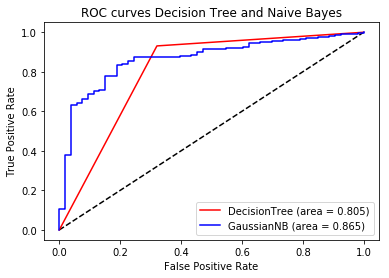

In [186]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Tree, tpr_Tree, color='red', label='DecisionTree (area = %0.3f)' % roc_auc_Tree)
plt.plot(fpr_nb, tpr_nb, color='blue', label='GaussianNB (area = %0.3f)' % roc_auc_nb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves Decision Tree and Naive Bayes')
plt.legend(loc='best')
plt.show()